<font face="Nunito" size=4>Making Code re-usable & Testing Actual Data
<font size=3><br>
    In this draft of the code we will
    <li> attempt to replicate things form the previous draft but usig functions instead of plain code out in the open
    <li> use the same dat that will beused in the project
    <li> Expand on the number and types of graphs we have to explain and compare our results
    <li> Hopefully apply these things to a different strategy
</font>
</font>

- At least one stock
- At least one index
- Hourly data
- Simple Moving Average indicator crossover rules
  - SMA-30
  - SMA-50


$Simple~Moving~Average$

> A lax *crossover* signal is adapted by referring to is the past 30 periods simple moving average of prices (SMA-**30**) is
above or below the past 50 periods simple moving average of prices (SMA-**50**). A buy (sell) signal is taken to have been generated when the SMA-**30** exceeds (drops below) the SMA-**50**.


- (i) When the SMA-30 crosses above the SMA-50, this constitutes a buy signal and any short positions are closed and a long position is opened.
- (ii) When the SMA-30 crosses below the SMA-50, this constitutes a buy signal and any long positions are closed and a short position is opened

$Volatility~Filter~–~Average~True~Range~(ATR)$


Current ATR = \[ ( Prior ATR × (n − 1)) + Current TR \] $\div$ n *$~~~~$ formula (1)*

where $n$ is the user-defined number of periods,

Current TR = Max(−Current Low, Current High − Previous Close, Current Low − Previous Close) *$~~~~$ formula (2)*

<font face="Nunito" size=4>0. Imports</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.style.use("fivethirtyeight")
%matplotlib inline

<font face="Nunito" size=4>I. Load Data into a DataFrame<br><br>
<font size=3>
We will be using the following data:
    <li> Hourly data from the S\&P500,from 1998-01-02 9am to 2020-03-09 3pm, from the QuantConnect [Lean pacakge Github](https://github.com/QuantConnect/Lean)
    <li> Daily data from the S\&P500, from 2007-01-03 to 2020-12-31, from [Yahoo! Finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC)

Data will be trimmed in order to compare across the same ranges.
</font>
</font>

QuantConnect Data:
- columns: time, close, high, low, open, volume
- dates: as listed above
- For some reason, the values of Close, High, Low, Open are multiplied by 1000. We'll divided ot make them match the Yahoo! data.

Yahoo!Finance
- columns: date, open, high, low, close, adj close, volume
- dates: as listed above
- ticker in Yahoo! Finance: ^GSPC


In [41]:
# QC
# The QuantConnect data doesn't have headers, so we add some.
# We use converters to handle the x1000 issue with the index values.
# We do not import the volume column.
f00 = lambda str_num: (int(str_num)/1000)
qcdf = pd.read_csv("data_files/quantconnect_hourly_spy.csv",parse_dates=[0],
                   names=["time", "close", "high", "low", "open"],
                   usecols=range(5),
                   converters={"close":f00, "high":f00, "low":f00, "open":f00})
# YF
yfdf = pd.read_csv("data_files/YFSnp500_2007-20_GSPC.csv",parse_dates=[0],
                   names=["date", "open", "high", "low", "close", "adjClose"],
                   header=0, # explicitly says the first row is a header so we can override the names
                   usecols=range(6))

- Acsending order

In [46]:
qcdf[qcdf.time >= "2007-01-03"]

,time,close,high,low,open
15814,2007-01-03 09:00:00,1422.7,1427.8,1419.3,1423.0
15815,2007-01-03 10:00:00,1420.5,1428.4,1419.9,1425.8
15816,2007-01-03 11:00:00,1425.8,1427.0,1425.1,1425.9
15817,2007-01-03 12:00:00,1425.8,1426.9,1423.9,1425.9
15818,2007-01-03 13:00:00,1425.6,1426.0,1420.0,1420.5
...,...,...,...,...,...
38950,2020-03-09 11:00:00,2786.1,2840.8,2780.2,2827.0
38951,2020-03-09 12:00:00,2826.9,2841.4,2790.1,2797.1
38952,2020-03-09 13:00:00,2796.8,2807.1,2753.5,2758.5
38953,2020-03-09 14:00:00,2758.2,2776.3,2734.6,2765.9


- verify that the datetimein the QuantConnect data is indeed a datetime object

In [43]:
qcdf.time[0]

Timestamp('1998-01-02 09:00:00')

In [45]:
yfdf

,date,open,high,low,close,adjClose
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985
...,...,...,...,...,...,...
3520,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059
3521,2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107
3522,2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3727.040039
3523,2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3732.040039


- Since the data on the S&P 500 comes from two different sources, QuantConnect and Yahoo!Finance, we will observe differences in the OHLC values. 
- This isn not an issuse for what we'd like to test.

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>II. Visually Show the Close Price</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>III. Calculate the 3 Moving Averages</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>IV. Visualize the Closing Price along with the Moving Averages</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>V. Add the EMAs to the Dataset</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>VI. Create the Function to Buy and Sell the Stock (i.e. the Strategy)<br><br>
<font size=3>Our data is in ascending order. We will later on `shift()` a series of indicators *down* by one row, such that<br>
&emsp;&emsp; - the indicator for day X is aligned with the data/price for day X+1<br>
&emsp;&emsp; - (alt: the indictor for day X-1 is aligned with data for day X<br>
<br></font></font>

Therfore, we will do this in two parts.
- First: Create the BUY/SELL criteria/indicator/signals. With DataFrames this is sometimes called a *mask*.
- Second: Apply the (boolean) mask to the correct row of data to simulate the buy/sell at that price.



#### VI-0: Strategy Recap and Reformat

#### VI-1: Create the Buy and Sell Indicator/Flags/Mask

#### VI-2:  Apply the (boolean) mask to the correct row of data

This was not done in the video and is extra. Now that we have signals for each day, we can use this signal to tell use what to do tomorrow. Therefore, we can consider tomorrows gain/loss our own gain/loss if we had followed the strategy.

We verified using `np.logical_not` that our Buy and Sell columns were just opposites. Again, this is ignoring day one, because all EMAs have an **equal** value on that day, and out strategy only uses $>$ or$<~$. In any case, this means we only need **one** of the columns. If Buy is `True`, we know Sell is `False`, and if Buy is `False`, we know Sell is `True`. No need to check the other column.

**Magic Formula**  
Gain or Loss / Profit or Loss/ PnL equals:  
$\Rightarrow$ (True or False inidcator yesterday) $~\times~$ Today's Price Change
- In Python `True` is `1` and `False` is `0` so `True * -4` = -4, and `False * -2.5` = 0
- Obviously the positive number case works the same way. We use this to determine PnL.
- You can use absolute change and aggregate with addition or percent change and aggreate with multiplication.

$\Uparrow$ As we can see now Buy = 1 and Sell = -1.  
We apply (multiply) these to the `PriceChange` column. It actualy works that if the strategy says "Sell" (-1) and the maakret dropped (PriceChange is negative), then we "gain" on that day.

$\Downarrow$ The strategy in action
- If we were always LONG the market/secutiry, our PnL would mirror the `PriceChange` column. Similarly it would be the opposite of the PriceChange column if we were akways SHORT. Our true PnL will come from the sum of products of `PriceChange` and `Decicion`.
- With this sum of products we will have the cumulative PnL over the entire date span

The values in our `PercentChange` column can be added to $1$ to get the relative change since the prevous day.  
For example $0.027229$ becomes $1.027229$ - an increase. Also $-0.020305$ becomes  $1 +~-0.020305~=~0.97695$ - a 
decrease.
- By adding 1 we create a today-reative-to-yesterday value.
- We can multiply thes enumbers together for a cummulative aggregation of the gain/loss over the timeframe.
* **We actually should not add the 1 in until after we incorporate the `Decision`.

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>VII. Plots<br><br>
<font size=3>We'd like to look at plots of the following:<br>
    <li> The points when our strategy told us to BUY (our buy signals).
    <li> The points when our strategy told us to SELL.
</font>
</font>

<font face="Nunito" size=4>...</font>

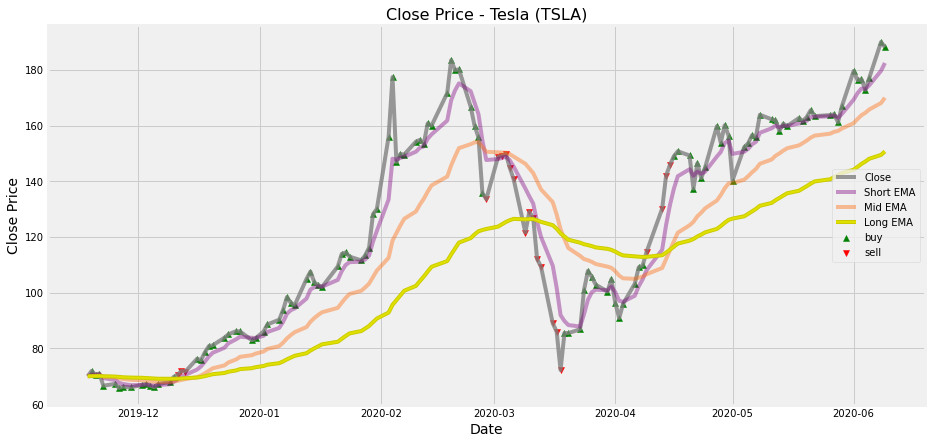

In [22]:
# We reuse most of the code from the previous plot
plt.figure(figsize=(14,7))
plt.title("Close Price - Tesla (TSLA)", fontsize=16)
plt.plot(df1.Close, label = "Close", color="grey", alpha=0.8)
# Now plot the EMA data
plt.plot(df1.SEMA, label = "Short EMA", color="purple", alpha=0.4)
plt.plot(df1.MEMA, label = "Mid EMA", color="#ff6600", alpha=0.4)
plt.plot(df1.LEMA, label = "Long EMA", color="#ffff00", alpha=0.4
         ,linewidth=2
         ,path_effects=[pe.Stroke(linewidth=4, foreground='#cccc00'), pe.Normal()])
# ----
# Now let's plot the Buy and Sell signals
    # we need to revoer the price when Buy=Treu, but not when Buy=False
    # We need to recover the price when Sell=True, but not when Sell=False
    # These need to be in separate Series objects

    # ---- we make the Series
truebuyprice = df1.Buy * df1.Close
truebuyprice = truebuyprice.replace(0,np.NAN)
truesellprice = df1.Sell * df1.Close
truesellprice = truesellprice.replace(0,np.NAN)
    # we plot each series
plt.scatter(df1.index, truebuyprice, color="green", marker="^", label="buy")
plt.scatter(df1.index, truesellprice, color="red", marker="v", label="sell")
    # ----
# ----
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>